Modeling and testing grounds

In [2]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.models import load_model

from numpy.random import seed
from tensorflow import set_random_seed

from skimage.transform import resize

import datetime
from tqdm import tqdm_notebook
import pickle

Using TensorFlow backend.


In [3]:
seed(42)
set_random_seed(42)

## Modeling and Evaluation Functions

Writing multiple functions to facilitate creating different datasets, modeling over different datasets and/or different hyperparameters, and evaluating the different models using graphs




In [4]:
class PnemoniaTargetMapIsWeird(AssertionError):
    """Raise this when the target is not mapped to 2 or 3 outputs"""
    pass

In [5]:
def create_pic_df(data, df_detailed, image_size = (128,128)):
    
    print('---Enter DataFrame Construction Function---')
    
    ## Data Prep
    # Need to define df_detailed somewhere
    data.drop_duplicates(inplace=True)
    merged_df = df_detailed.merge(data, on='patientId')
    
    print('---Create Pixel Array Labels---')
    
    # Create the column labels for the pixel arrays
    pixel_labels = []
    for i in range(image_size[0] * image_size[1]):
        pixel_labels.append("pixel"+str(i))
    
    print('---Create Total Pixel Array---')
    
    # Create the total pixel array
    huge_pixel_array = []
    for o in tqdm_notebook(range(merged_df.shape[0])):
        # Get the image data
        patientId = merged_df.iloc[o]['patientId']
        dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
        dcm_data = pydicom.read_file(dcm_file)
        im = dcm_data.pixel_array

        # Convert the image into a 1d array of pixels
        curr_pixel_array = []
        for i in resize(im, image_size): 
            curr_pixel_array.extend(i)
        huge_pixel_array.append(curr_pixel_array)

    print('---Create Dataframe---')
        
    # Creating the DataFrame
    temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)
    temp['class'] = merged_df['class']
    return temp

In [21]:
def model(data, model_name = "default_model_name", image_size = (128,128), y_map = {
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}, EPOCHS = 20, train_size = 0.75, metrics = ['accuracy'], BATCH_SIZE = 10 ):
    """
    Args:
        data (Pandas DataFrame): cols=['class', all of the pixel data]
        
        model_name (str): The name with which to save the model
        
        image_size (touple: (int,int)): The width and height in pixels to scale the images. Max 1024x1024. This might be more finickey that I would've thought.
        
        y_map (dict): A dictionary mapping the target values to integers (0-?)
        
    Returns:
        Keras Model fit on the data.
        Saves the model to ../data/models/model_name datetime.h5
    """
    print('---Enter Function---')
    
    seed(42)
    set_random_seed(42)

    # Create target
    y = data['class']
    y = y.map(lambda x: y_map[x])
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), y, 
                                                        stratify=y, random_state=42, train_size = train_size)
    
    # Transform target into arrays of integers
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    # Reshape the X_train and X_test 
    X_train_re = X_train.values.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
    X_test_re = X_test.values.reshape(X_test.shape[0], image_size[0], image_size[1], 1)
    
    print('---Modeling---')
    
    ## Modeling
    # Initialize Model
    model_convolutional = Sequential()

    # First Conv / Pool 
    model_convolutional.add(Conv2D(filters = 12, #6
                                   kernel_size = 3,
                                   activation = 'relu',
                                   input_shape = (image_size[0], image_size[1], 1)
                                  ))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Second Conv/ Pool
    model_convolutional.add(Conv2D(filters=16, kernel_size=3, 
                                   activation='relu'))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model_convolutional.add(Dropout(0.8))
    model_convolutional.add(Flatten())

    # Densely Connected Layers
    model_convolutional.add(Dense(300, activation='relu')) #512
    model_convolutional.add(Dropout(0.4)) #0.5
    model_convolutional.add(Dense(80, activation='relu')) #128
    model_convolutional.add(Dropout(0.4))#0.5
    
    # Output Layer
    if len(set(y_map.values())) == 3:
        model_convolutional.add(Dense(3, activation='softmax'))
    elif len(set(y_map.values())) == 2:
        model_convolutional.add(Dense(2, activation='softmax'))
    else:
        raise PnemoniaTargetMapIsWeird("target is not mapped to 2 or 3 outputs")


    model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = 'adam', 
                            metrics = metrics)
    
    # Train Model
    trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_test_re, y_test_c)
                       )


    file_name = '../data/models/' + model_name + ' ' + str(datetime.datetime.now()) 

    # Save Model        
    try:
        model_file_name = file_name + '_model.h5'
        model_convolutional.save(model_file_name)
        print('Model saved as: ' + model_file_name)
        
    except Exception as e:
        print('+++++Model did not save++++++')
        print(e)
        
    # Save History
    try:
        history_file_name = file_name + '_history.pk'
        pickle_file = open(history_file_name, 'wb')
        pickle.dump(trained_convolutional, pickle_file) 
        pickle_file.close()
        print('History saved as: ' + history_file_name)
        
    except Exception as e:
        print('+++++History did not save++++++')
        print(e)
        
        
    return trained_convolutional, model_convolutional, model_name, model_file_name, history_file_name



In [7]:
# Function that displays pertinant information regarding the quality of the model

def evaluate_model (model, model_name = 'default', size=6):
    
    """
    Args:
        model: A trained model with 
        
    Output:
        Returns nothing. Prints out - plots comparing test set with training set on 
        each of the metrics (minimum: loss).
    
    """
    
    # checking out the different classes in the testing case and predictions
    
    # confusion matrix?
    
    keys=[]
    for i in model.history.keys():
        if i[0:3] != 'val':
            keys.append(i)
    
    fig, ax = plt.subplots(len(keys), 1, figsize = (size, size*len(keys))) 
    fig.suptitle('Model: ' + model_name, fontsize=16)
    
    index = 0
    for i in keys:
        # Plot of the Loss for the train and testingsets
        ax[index].plot(model.history[i], label=i.capitalize())
        ax[index].plot(model.history['val_'+i], label='Val '+i.capitalize())
        ax[index].legend()
        ax[index].set_title(i.capitalize())
        index+=1


## Initial Variables

In [8]:
# Lung Opacity == Pneumonia
y_map_3 = { # Normal, Pneumonia, or not normal but not pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}

y_map_2 = { # Either Pneumonia or Not Pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":0
}

adult_data = pd.read_csv('../data/adult_patient_data.csv')
df_detailed = pd.read_csv('../data/stage_1_detailed_class_info.csv')


In [9]:
models = {}

## Some Initial Modeling

In [ ]:
# Current Parameters
options = 3


NUM_IMAGES = 6000 #pic_df.shape[0]
EPOCHS = 20
IMAGE_SIZE = (128,128)
TRAIN_SIZE = 0.8
METRICS = ['accuracy']

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [ ]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

In [ ]:
%%time



test_model_history, test_model_real, most_recent_model_name = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, EPOCHS=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS)



In [ ]:
models[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'history':test_model_history,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}

# Save the list of models and parameters 
model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models, file_object)
file_object.close()


In [ ]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)


In [ ]:
# This shows the different levels in my NN
test_model_history.model.get_config()

In [ ]:
models[most_recent_model_name]['history'].model.predict(pic_df.drop(columns='class').iloc[1,:].values)

## Predicting
Creating predictions and getting useful, interpretable results from the models.

In [ ]:
%%time

# Predicting on the images
X = pic_df.drop(columns='class')
pred_x = X.values.reshape(X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
preds = test_model_real.predict(pred_x)

In [ ]:
# Converting the target values to the 
y_real = pic_df['class']
y_real = y_real.map(lambda x: CURR_MAP[x])

In [ ]:
#preds = pd.DataFrame(data=preds, columns=[])
new_preds = []
for i in range(len(preds)):
     new_preds.append(preds[i].argmax())
print(new_preds[0:20])

In [ ]:
# Print out the actual values against their predicted values
index = 0
for i in zip(y_real, new_preds):
    print(i)
    index+=1
    if index > 20:
        break

## End Predicting

In [10]:
display(models)

{}

In [ ]:
# Loading in the list of models/parameters

model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'rb')

models = pickle.load(file_object)
file_object.close()

display(models)

# What am I trying to do now?
- start changing models around potentially using 
    - Stochastic gradient descent
    - [R-CNN (or a different iteration)](https://heartbeat.fritz.ai/the-5-computer-vision-techniques-that-will-change-how-you-see-the-world-1ee19334354b)
    - [SpatialDropout2D](https://keras.io/layers/core/#spatialdropout2d)


In [20]:
df_detailed['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

## Modeling over full adult set for 80 epochs

In [22]:
# Current Parameters
options = 3


NUM_IMAGES = adult_data.shape[0]
EPOCHS = 80
IMAGE_SIZE = (64,64)
TRAIN_SIZE = 0.8
METRICS = ['accuracy']
BATCH_SIZE = 10

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [12]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



---Create Dataframe---
CPU times: user 6min 46s, sys: 7.97 s, total: 6min 54s
Wall time: 7min 24s


In [23]:
%%time

test_model_history, test_model_real, most_recent_model_name, model_file_path, history_file_path = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, EPOCHS=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS, BATCH_SIZE=BATCH_SIZE)



---Enter Function---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling---
Train on 19556 samples, validate on 4889 samples
Epoch 1/80
19556/19556 [==============================] - 46s 2ms/step - loss: 0.9492 - acc: 0.5136 - val_loss: 0.8701 - val_acc: 0.5727
Epoch 2/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.8972 - acc: 0.5560 - val_loss: 0.8758 - val_acc: 0.5764
Epoch 3/80
19556/19556 [==============================] - 46s 2ms/step - loss: 0.8830 - acc: 0.5676 - val_loss: 0.8451 - val_acc: 0.5844
Epoch 4/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.8675 - acc: 0.5805 - val_loss: 0.8385 - val_acc: 0.5971
Epoch 5/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.8561 - acc: 0.5859 - val_loss: 0.8225 - val_acc: 0.6022
Epoch 6/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.8510 - acc: 0.5912 - val_loss: 0.8052 - val_acc: 0.6179
Epoch 7/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.8454 - acc: 0.5934 - val_loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19556/19556 [==============================] - 45s 2ms/step - loss: 0.7795 - acc: 0.6344 - val_loss: 0.7934 - val_acc: 0.6222
Epoch 53/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.7814 - acc: 0.6357 - val_loss: 0.7604 - val_acc: 0.6474
Epoch 54/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.7815 - acc: 0.6333 - val_loss: 0.7656 - val_acc: 0.6521
Epoch 55/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7841 - acc: 0.6310 - val_loss: 0.7572 - val_acc: 0.6517
Epoch 56/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7827 - acc: 0.6348 - val_loss: 0.7652 - val_acc: 0.6461
Epoch 57/80
 2320/19556 [==>...........................] - ETA: 36s - loss: 0.7822 - acc: 0.6319

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19556/19556 [==============================] - 45s 2ms/step - loss: 0.7766 - acc: 0.6339 - val_loss: 0.7694 - val_acc: 0.6304
Epoch 65/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7751 - acc: 0.6375 - val_loss: 0.7641 - val_acc: 0.6439
Epoch 66/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7763 - acc: 0.6371 - val_loss: 0.7675 - val_acc: 0.6445
Epoch 67/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7788 - acc: 0.6308 - val_loss: 0.7875 - val_acc: 0.6331
Epoch 68/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7721 - acc: 0.6373 - val_loss: 0.7712 - val_acc: 0.6423
Epoch 69/80
 2180/19556 [==>...........................] - ETA: 36s - loss: 0.7906 - acc: 0.6390

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19556/19556 [==============================] - 45s 2ms/step - loss: 0.7753 - acc: 0.6388 - val_loss: 0.8131 - val_acc: 0.6208
Epoch 76/80
19556/19556 [==============================] - 44s 2ms/step - loss: 0.7704 - acc: 0.6394 - val_loss: 0.7577 - val_acc: 0.6523
Epoch 77/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.7653 - acc: 0.6399 - val_loss: 0.7754 - val_acc: 0.6396
Epoch 78/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.7665 - acc: 0.6444 - val_loss: 0.7626 - val_acc: 0.6486
Epoch 79/80
19556/19556 [==============================] - 45s 2ms/step - loss: 0.7672 - acc: 0.6405 - val_loss: 0.7692 - val_acc: 0.6490
Epoch 80/80
 7330/19556 [==========>...................] - ETA: 26s - loss: 0.7623 - acc: 0.6413

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
most_recent_model_name

'adult_data_3_options'

In [25]:
# New way to save the models after every new model creation

# Save all of the stats about each model I've run

# Loading in the list of models/parameters
model_pickle_file_name = '../data/models/models_dict.pk'
file_object = open(model_pickle_file_name,'rb')
models_dict = pickle.load(file_object)
file_object.close()


# Add the most recent model to the list
models_dict[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'model_location':model_file_path,
    'history_location':history_file_path,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}


# Save the list of models and parameters 
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models_dict, file_object)
file_object.close()

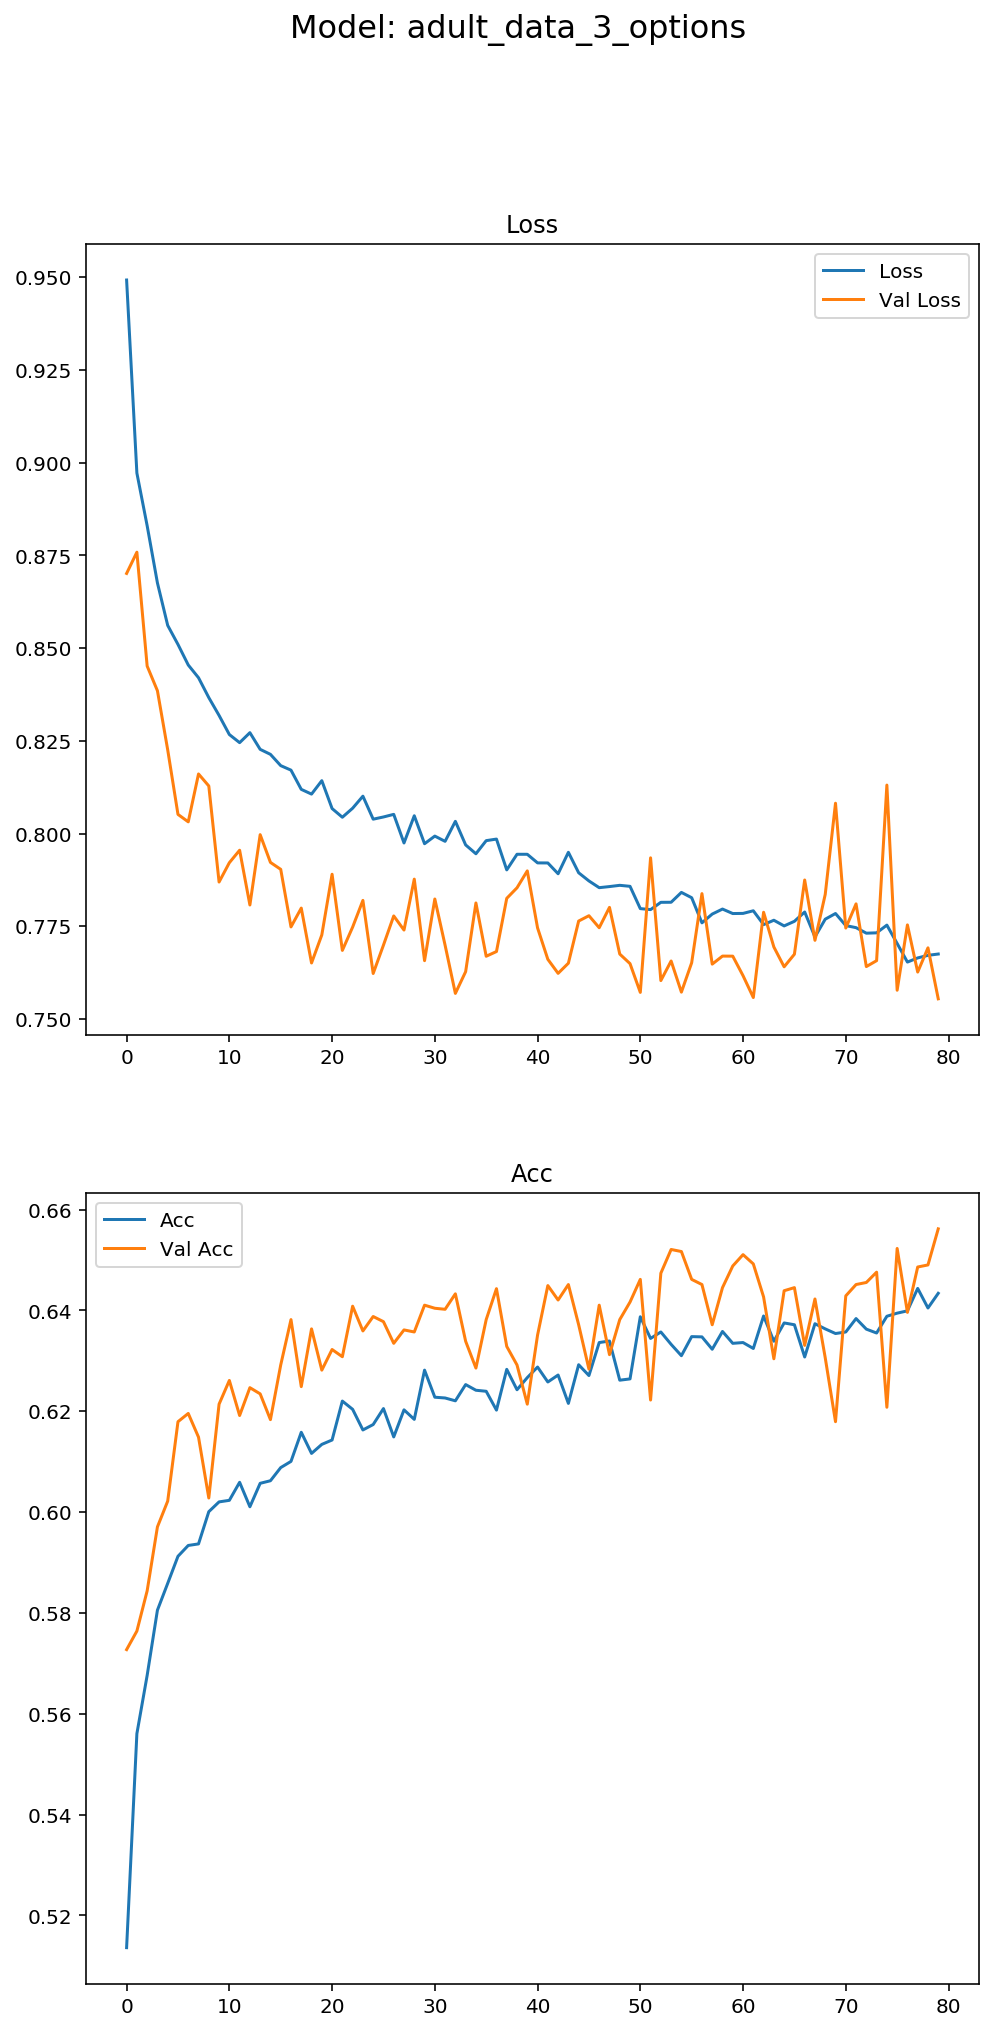

In [26]:
graph_size = 8
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)
